# COL3A1

In [38]:
import gpsea
import hpotk

store = hpotk.configure_ontology_store()
hpo = store.load_minimal_hpo()
print(f'Loaded HPO v{hpo.version}')
print(f"Using genophenocorr version {gpsea.__version__}")

Loaded HPO v2024-12-12
Using genophenocorr version 0.9.1


# COL3A1
We user the [Matched Annotation from NCBI and EMBL-EBI (MANE)](https://www.ncbi.nlm.nih.gov/refseq/MANE/) transcript and the corresponding protein identifier for COL3A1.

In [39]:
gene_symbol = 'COL3A1'
mane_tx_id = 'NM_000090.4'
mane_protein_id = "NP_000081.2" #collagen alpha-1(III) chain preproprotein"

In [40]:
from ppktstore.registry import configure_phenopacket_registry
from gpsea.preprocessing import configure_caching_cohort_creator, load_phenopackets

from ppktstore.registry import configure_phenopacket_registry
phenopacket_registry = configure_phenopacket_registry()
with phenopacket_registry.open_phenopacket_store("0.1.23") as ps:
    phenopackets = tuple(ps.iter_cohort_phenopackets(gene_symbol))
len(phenopackets)


cohort_creator = configure_caching_cohort_creator(hpo)
cohort, validation = load_phenopackets(
    phenopackets=phenopackets, 
    cohort_creator=cohort_creator,
)

validation.summarize()

Individuals Processed: 100%|██████████| 41/41 [00:00<00:00, 79.32individuals/s]
Validated under permissive policy
No errors or warnings were found


In [41]:
from gpsea.view import CohortViewer
cv = CohortViewer(hpo=hpo)
cv.process(cohort=cohort, transcript_id=mane_tx_id)

n,HPO Term
29,Bruising susceptibility
25,Dermal translucency
19,Finger joint hypermobility
14,Spontaneous pneumothorax
12,Arterial rupture
11,Arterial dissection
9,Gingival fragility
7,Aortic dissection
6,Talipes equinovarus
6,Polymicrogyria


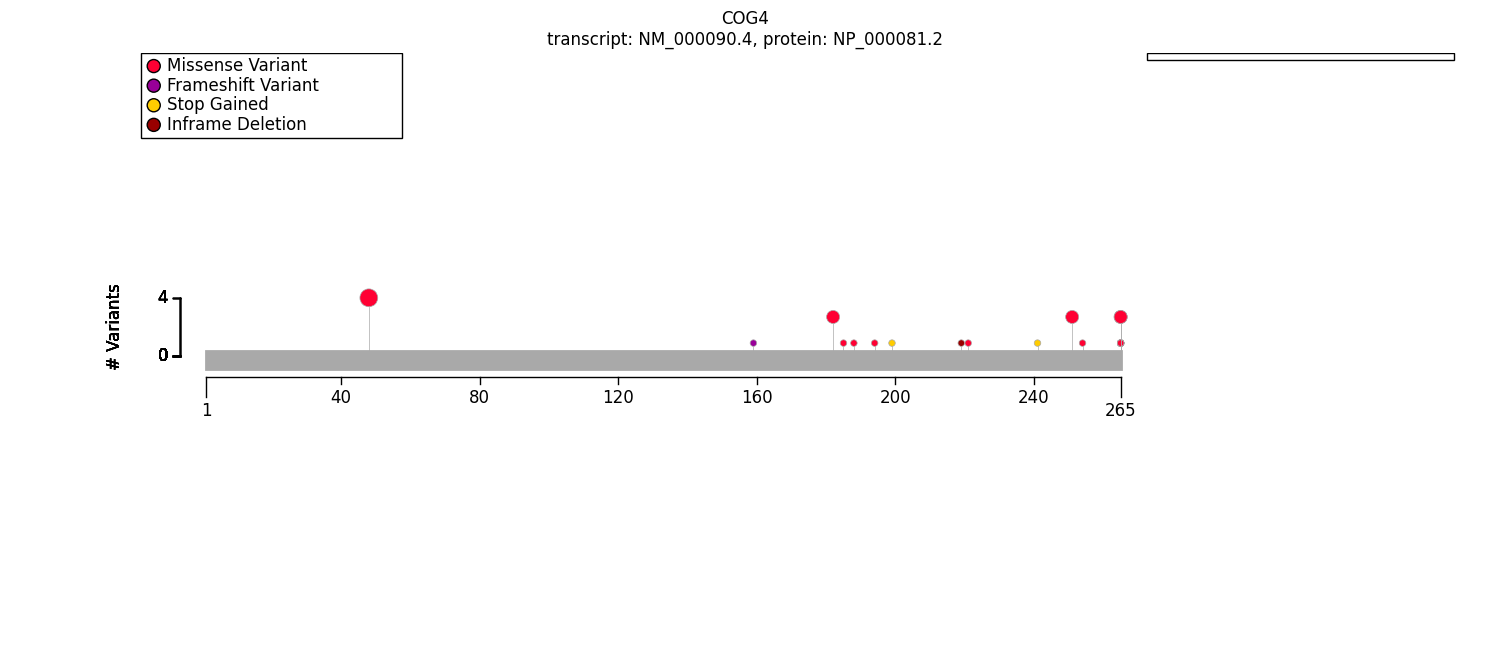

In [42]:
from gpsea.model.genome import GRCh38
from gpsea.model import ProteinMetadata
from gpsea.preprocessing import VVMultiCoordinateService
from gpsea.view import ProteinVisualizer
import matplotlib.pyplot as plt
import pandas as pd
txc_service = VVMultiCoordinateService(genome_build=GRCh38)
tx_coordinates = txc_service.fetch(mane_tx_id)
features = []
df = pd.DataFrame(features, columns=["region","category","start", "end"])
protein_meta = ProteinMetadata.from_feature_frame(protein_id=mane_protein_id, label="COG4", features=df, protein_length=265)


COL3A1_fig, ax = plt.subplots(figsize=(15, 8))
visualizer = ProteinVisualizer()
visualizer.draw_protein_diagram(
    tx_coordinates,
    protein_meta,
    cohort,
    ax=ax,
)
COL3A1_fig.tight_layout()

In [43]:
from gpsea.view import CohortVariantViewer

viewer = CohortVariantViewer(tx_id=mane_tx_id)
viewer.process(cohort)

Count,Variant key,HGVS,Overlapping Exons,Effects
4,2_188984825_188984825_C_G,c.145C>G (p.Pro49Ala),2,missense
2,2_188988099_188988099_G_A,c.547G>A (p.Gly183Ser),6,missense
1,2_188995728_188995728_G_T,c.1546G>T (p.Gly516Trp),22,missense
1,2_188988117_188988117_G_C,c.565G>C (p.Gly189Arg),6,missense
1,2_188990316_188990316_G_A,c.754G>A (p.Gly252Ser),10,missense
1,2_188994577_188994577_G_A,c.1330G>A (p.Gly444Arg),19,missense
1,2_189001555_189001555_G_A,c.2357G>A (p.Gly786Glu),34,missense
1,2_189007500_189007500_G_C,c.3256G>C (p.Gly1086Arg),45,"missense, splice region"
1,2_189003027_189003027_G_A,c.2518G>A (p.Gly840Arg),36,missense
1,2_188996179_188996179_G_A,c.1662+1G>A (-),-,splice donor


# Genotype-Phenotype Correlation (GPC) Analysis

In [44]:
from gpsea.analysis.pcats import configure_hpo_term_analysis
analysis = configure_hpo_term_analysis(hpo)

from gpsea.analysis.clf import prepare_classifiers_for_terms_of_interest
pheno_clfs = prepare_classifiers_for_terms_of_interest(
    cohort=cohort,
    hpo=hpo,
)

In [45]:
from gpsea.model import VariantEffect
from gpsea.analysis.clf import monoallelic_classifier
from gpsea.analysis.predicate import variant_effect
from gpsea.view import MtcStatsViewer

is_missense = variant_effect(VariantEffect.MISSENSE_VARIANT, mane_tx_id)
missense_clf = monoallelic_classifier(
    a_predicate=is_missense,
    b_predicate=~is_missense,
    a_label='Missense', 
    b_label='Other'
)

missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=missense_clf,
    pheno_clfs=pheno_clfs,
)

mtc_viewer = MtcStatsViewer()
mtc_viewer.process(missense_result)

Code,Reason,Count
HMF01,Skipping term with maximum frequency that was less than threshold 0.4,77
HMF03,Skipping term because of a child term with the same individual counts,4
HMF08,Skipping general term,48
HMF09,Skipping term with maximum annotation frequency that was less than threshold 0.4,36


In [46]:
from gpsea.view import summarize_hpo_analysis
summarize_hpo_analysis(hpo, missense_result)

Allele group                                       Missense          Other  \
                                                      Count Percent  Count   
Gingival fragility [HP:0034518]                        3/19     16%   6/12   
Dermal translucency [HP:0010648]                      12/19     63%  11/14   
Bruising susceptibility [HP:0000978]                  15/20     75%  12/14   
Finger joint hypermobility [HP:0006094]               10/19     53%   9/14   
Spontaneous pneumothorax [HP:0002108]                  8/21     38%   6/14   
Small joint hypermobilty [HP:0430046]                 10/10    100%    9/9   
Abnormality of joint mobility [HP:0011729]            10/10    100%    9/9   
Abnormality of hand joint mobility [HP:0006256]       10/10    100%    9/9   
Abnormal finger morphology [HP:0001167]               10/10    100%    9/9   
Abnormal appendicular skeleton morphology [HP:0...    10/10    100%    9/9   
Subcutaneous hemorrhage [HP:0001933]                  15/15    100%  12/12   
Abnormal blood vessel morphology [HP:0033353]         10/10    100%    8/8   

Allele group                                                                   \
                                                   Percent Corrected p values   
Gingival fragility [HP:0034518]                        50%           0.674278   
Dermal translucency [HP:0010648]                       79%           1.000000   
Bruising susceptibility [HP:0000978]                   86%           1.000000   
Finger joint hypermobility [HP:0006094]                64%           1.000000   
Spontaneous pneumothorax [HP:0002108]                  43%           1.000000   
Small joint hypermobilty [HP:0430046]                 100%           1.000000   
Abnormality of joint mobility [HP:0011729]            100%           1.000000   
Abnormality of hand joint mobility [HP:0006256]       100%           1.000000   
Abnormal finger morphology [HP:0001167]               100%           1.000000   
Abnormal appendicular skeleton morphology [HP:0...    100%           1.000000   
Subcutaneous hemorrhage [HP:0001933]                  100%           1.000000   
Abnormal blood vessel morphology [HP:0033353]         100%           1.000000   

Allele group                                                  
                                                    p values  
Gingival fragility [HP:0034518]                     0.056190  
Dermal translucency [HP:0010648]                    0.455080  
Bruising susceptibility [HP:0000978]                0.672174  
Finger joint hypermobility [HP:0006094]             0.722801  
Spontaneous pneumothorax [HP:0002108]               1.000000  
Small joint hypermobilty [HP:0430046]               1.000000  
Abnormality of joint mobility [HP:0011729]          1.000000  
Abnormality of hand joint mobility [HP:0006256]     1.000000  
Abnormal finger morphology [HP:0001167]             1.000000  
Abnormal appendicular skeleton morphology [HP:0...  1.000000  
Subcutaneous hemorrhage [HP:0001933]                1.000000  
Abnormal blood vessel morphology [HP:0033353]       1.000000

In [47]:
import gpsea.analysis.predicate
from gpsea.model.genome import Region
from gpsea.analysis.predicate import protein_region

is_triple = protein_region(region=Region(start=167, end=1196), tx_id=mane_tx_id)

triple_clf = monoallelic_classifier(
    a_predicate=is_triple,
    b_predicate=~is_triple,
    a_label='is_triple', 
    b_label='Other'
)

triple_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=triple_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, triple_result)


Allele group                                       is_triple         Other  \
                                                       Count Percent Count   
Dermal translucency [HP:0010648]                       15/24     62%   8/9   
Finger joint hypermobility [HP:0006094]                12/24     50%   7/9   
Spontaneous pneumothorax [HP:0002108]                   9/26     35%   5/9   
Bruising susceptibility [HP:0000978]                   19/25     76%   8/9   
Small joint hypermobilty [HP:0430046]                  12/12    100%   7/7   
Abnormality of joint mobility [HP:0011729]             12/12    100%   7/7   
Abnormality of hand joint mobility [HP:0006256]        12/12    100%   7/7   
Abnormal finger morphology [HP:0001167]                12/12    100%   7/7   
Abnormal appendicular skeleton morphology [HP:0...     12/12    100%   7/7   
Subcutaneous hemorrhage [HP:0001933]                   19/19    100%   8/8   
Abnormal blood vessel morphology [HP:0033353]          14/14    100%   4/4   

Allele group                                                                   \
                                                   Percent Corrected p values   
Dermal translucency [HP:0010648]                       89%                1.0   
Finger joint hypermobility [HP:0006094]                78%                1.0   
Spontaneous pneumothorax [HP:0002108]                  56%                1.0   
Bruising susceptibility [HP:0000978]                   89%                1.0   
Small joint hypermobilty [HP:0430046]                 100%                1.0   
Abnormality of joint mobility [HP:0011729]            100%                1.0   
Abnormality of hand joint mobility [HP:0006256]       100%                1.0   
Abnormal finger morphology [HP:0001167]               100%                1.0   
Abnormal appendicular skeleton morphology [HP:0...    100%                1.0   
Subcutaneous hemorrhage [HP:0001933]                  100%                1.0   
Abnormal blood vessel morphology [HP:0033353]         100%                1.0   

Allele group                                                  
                                                    p values  
Dermal translucency [HP:0010648]                    0.216638  
Finger joint hypermobility [HP:0006094]             0.240922  
Spontaneous pneumothorax [HP:0002108]               0.431768  
Bruising susceptibility [HP:0000978]                0.644458  
Small joint hypermobilty [HP:0430046]               1.000000  
Abnormality of joint mobility [HP:0011729]          1.000000  
Abnormality of hand joint mobility [HP:0006256]     1.000000  
Abnormal finger morphology [HP:0001167]             1.000000  
Abnormal appendicular skeleton morphology [HP:0...  1.000000  
Subcutaneous hemorrhage [HP:0001933]                1.000000  
Abnormal blood vessel morphology [HP:0033353]       1.000000

In [48]:
from gpsea.analysis.clf import diagnosis_classifier

dx_clf = diagnosis_classifier(
    diagnoses=('OMIM:130050', 'OMIM:618343'),
    labels=('Ehlers-Danlos syndrome, vascular type', 'Polymicrogyria with or without vascular-type EDS'),
)
dx_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=dx_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, dx_result)

Diagnosis                                          OMIM:130050          \
                                                         Count Percent   
Small joint hypermobilty [HP:0430046]                    19/19    100%   
Finger joint hypermobility [HP:0006094]                  19/33     58%   
Dermal translucency [HP:0010648]                         23/33     70%   
Talipes equinovarus [HP:0001762]                          4/32     12%   
Bruising susceptibility [HP:0000978]                     27/34     79%   
Joint hypermobility [HP:0001382]                         19/19    100%   
Abnormality of joint mobility [HP:0011729]               19/19    100%   
Abnormal finger morphology [HP:0001167]                  19/19    100%   
Abnormal appendicular skeleton morphology [HP:0...       19/19    100%   
Subcutaneous hemorrhage [HP:0001933]                     27/27    100%   
Abnormal systemic arterial morphology [HP:0011004]       16/16    100%   
Abnormal blood vessel morphology [HP:0033353]            18/18    100%   

Diagnosis                                          OMIM:618343          \
                                                         Count Percent   
Small joint hypermobilty [HP:0430046]                      2/5     40%   
Finger joint hypermobility [HP:0006094]                    0/3      0%   
Dermal translucency [HP:0010648]                           2/6     33%   
Talipes equinovarus [HP:0001762]                           2/5     40%   
Bruising susceptibility [HP:0000978]                       2/4     50%   
Joint hypermobility [HP:0001382]                           2/2    100%   
Abnormality of joint mobility [HP:0011729]                 2/2    100%   
Abnormal finger morphology [HP:0001167]                    1/1    100%   
Abnormal appendicular skeleton morphology [HP:0...         1/1    100%   
Subcutaneous hemorrhage [HP:0001933]                       2/2    100%   
Abnormal systemic arterial morphology [HP:0011004]         1/1    100%   
Abnormal blood vessel morphology [HP:0033353]              2/2    100%   

Diagnosis                                                              \
                                                   Corrected p values   
Small joint hypermobilty [HP:0430046]                        0.059289   
Finger joint hypermobility [HP:0006094]                      0.531291   
Dermal translucency [HP:0010648]                             0.531291   
Talipes equinovarus [HP:0001762]                             0.531291   
Bruising susceptibility [HP:0000978]                         0.558521   
Joint hypermobility [HP:0001382]                             1.000000   
Abnormality of joint mobility [HP:0011729]                   1.000000   
Abnormal finger morphology [HP:0001167]                      1.000000   
Abnormal appendicular skeleton morphology [HP:0...           1.000000   
Subcutaneous hemorrhage [HP:0001933]                         1.000000   
Abnormal systemic arterial morphology [HP:0011004]           1.000000   
Abnormal blood vessel morphology [HP:0033353]                1.000000   

Diagnosis                                                     
                                                    p values  
Small joint hypermobilty [HP:0430046]               0.004941  
Finger joint hypermobility [HP:0006094]             0.095238  
Dermal translucency [HP:0010648]                    0.162585  
Talipes equinovarus [HP:0001762]                    0.177097  
Bruising susceptibility [HP:0000978]                0.232717  
Joint hypermobility [HP:0001382]                    1.000000  
Abnormality of joint mobility [HP:0011729]          1.000000  
Abnormal finger morphology [HP:0001167]             1.000000  
Abnormal appendicular skeleton morphology [HP:0...  1.000000  
Subcutaneous hemorrhage [HP:0001933]                1.000000  
Abnormal systemic arterial morphology [HP:0011004]  1.000000  
Abnormal blood vessel morphology [HP:0033353]       1.000000

In [49]:
variant = cohort.get_variant_by_key("2_188988099_188988099_G_A") # c.547G>A (p.Gly183Ser)
variant.get_preferred_tx_annotation().transcript_id

'NM_000090.4'

In [50]:
from gpsea.analysis.predicate import VariantPredicate, variant_effect
from gpsea.model import Variant, VariantEffect

class AffectsGlycineResidue(VariantPredicate):
    """
    Return True iff this variant is missense and the reference residue is Gylcine.
    """
    def __init__(self):
        super().__init__()

    def get_question(self) -> str:
        return self.description

    def test(self, variant: Variant) -> bool:
        """
        Test if the `variant` is a missense variant that affects a REF Gylcine residue

        Args:
            variant: an instance of :class:`~gpsea.model.Variant` to test.

        Returns:
            bool: `True` if the variant is a missense variant that affects a REF Gylcine residue
        """
        is_missense =  variant_effect(VariantEffect.MISSENSE_VARIANT, variant.get_preferred_tx_annotation().transcript_id)
        return is_missense.test(variant) and "p.Gly" in variant.get_preferred_tx_annotation().hgvsp
    
    def description(self) -> str:
        return self.__str__()
    
    def name(self) -> str:
        return self.__str__()
    
    def variable_name(self) -> str:
        return self.__str__()

    def __str__(self) -> str:
        return "Is Glycine Missense"
    
    def __repr__(self):
        return self.__str__()

In [51]:
is_gly_missense = AffectsGlycineResidue()
is_gly_missense_clf = monoallelic_classifier(
    a_predicate=is_gly_missense,
    b_predicate=~is_gly_missense,
    a_label='Gly missense', 
    b_label='Other'
)

is_gly_missense_result = analysis.compare_genotype_vs_phenotypes(
    cohort=cohort,
    gt_clf=is_gly_missense_clf,
    pheno_clfs=pheno_clfs,
)
summarize_hpo_analysis(hpo, is_gly_missense_result)

Allele group                                       Gly missense          \
                                                          Count Percent   
Gingival fragility [HP:0034518]                            2/18     11%   
Dermal translucency [HP:0010648]                          11/18     61%   
Bruising susceptibility [HP:0000978]                      14/19     74%   
Finger joint hypermobility [HP:0006094]                    9/18     50%   
Spontaneous pneumothorax [HP:0002108]                      8/20     40%   
Small joint hypermobilty [HP:0430046]                       9/9    100%   
Abnormality of joint mobility [HP:0011729]                  9/9    100%   
Abnormality of hand joint mobility [HP:0006256]             9/9    100%   
Abnormal finger morphology [HP:0001167]                     9/9    100%   
Abnormal appendicular skeleton morphology [HP:0...          9/9    100%   
Subcutaneous hemorrhage [HP:0001933]                      14/14    100%   
Abnormal blood vessel morphology [HP:0033353]             10/10    100%   

Allele group                                        Other          \
                                                    Count Percent   
Gingival fragility [HP:0034518]                      7/13     54%   
Dermal translucency [HP:0010648]                    12/15     80%   
Bruising susceptibility [HP:0000978]                13/15     87%   
Finger joint hypermobility [HP:0006094]             10/15     67%   
Spontaneous pneumothorax [HP:0002108]                6/15     40%   
Small joint hypermobilty [HP:0430046]               10/10    100%   
Abnormality of joint mobility [HP:0011729]          10/10    100%   
Abnormality of hand joint mobility [HP:0006256]     10/10    100%   
Abnormal finger morphology [HP:0001167]             10/10    100%   
Abnormal appendicular skeleton morphology [HP:0...  10/10    100%   
Subcutaneous hemorrhage [HP:0001933]                13/13    100%   
Abnormal blood vessel morphology [HP:0033353]         8/8    100%   

Allele group                                                           \
                                                   Corrected p values   
Gingival fragility [HP:0034518]                              0.199433   
Dermal translucency [HP:0010648]                             1.000000   
Bruising susceptibility [HP:0000978]                         1.000000   
Finger joint hypermobility [HP:0006094]                      1.000000   
Spontaneous pneumothorax [HP:0002108]                        1.000000   
Small joint hypermobilty [HP:0430046]                        1.000000   
Abnormality of joint mobility [HP:0011729]                   1.000000   
Abnormality of hand joint mobility [HP:0006256]              1.000000   
Abnormal finger morphology [HP:0001167]                      1.000000   
Abnormal appendicular skeleton morphology [HP:0...           1.000000   
Subcutaneous hemorrhage [HP:0001933]                         1.000000   
Abnormal blood vessel morphology [HP:0033353]                1.000000   

Allele group                                                  
                                                    p values  
Gingival fragility [HP:0034518]                     0.016619  
Dermal translucency [HP:0010648]                    0.282799  
Bruising susceptibility [HP:0000978]                0.426304  
Finger joint hypermobility [HP:0006094]             0.482424  
Spontaneous pneumothorax [HP:0002108]               1.000000  
Small joint hypermobilty [HP:0430046]               1.000000  
Abnormality of joint mobility [HP:0011729]          1.000000  
Abnormality of hand joint mobility [HP:0006256]     1.000000  
Abnormal finger morphology [HP:0001167]             1.000000  
Abnormal appendicular skeleton morphology [HP:0...  1.000000  
Subcutaneous hemorrhage [HP:0001933]                1.000000  
Abnormal blood vessel morphology [HP:0033353]       1.000000

# Summary

In [52]:
from gpseacs.report import  GPAnalysisResultSummary, GpseaAnalysisReport

f_results =  (
 GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ), GPAnalysisResultSummary.from_multi(
        result=missense_result,
    ),
    GPAnalysisResultSummary.from_multi(
        result=triple_result,
    ), 
    GPAnalysisResultSummary.from_multi(
        result=dx_result,
    ), 
     GPAnalysisResultSummary.from_multi(
        result=is_gly_missense_result,
    ), 
)

caption = "No significant GPC identified. Frank et al (2015) found that glycine missense variants were associated with a higher degree of severity in a cohort of 215 individuals. Primary data was not made available."

report = GpseaAnalysisReport(
    name=gene_symbol,
    cohort=cohort,
    fet_results=f_results,
    gene_symbol=gene_symbol,
    mane_tx_id=mane_tx_id,
    mane_protein_id=mane_protein_id,
    caption=caption,
)

In [53]:
from gpseacs.report import GpseaNotebookSummarizer
summarizer = GpseaNotebookSummarizer(hpo=hpo, gpsea_version=gpsea.__version__)
summarizer.summarize_report(report=report)

Genotype (A),Genotype (B),Tests performed,Significant tests
Missense,Other,12,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Missense,Other,12,0
Genotype (A),Genotype (B),Tests performed,Significant tests
is_triple,Other,11,0
Genotype (A),Genotype (B),Tests performed,Significant tests
OMIM:130050,OMIM:618343,12,0
Genotype (A),Genotype (B),Tests performed,Significant tests
Gly missense,Other,12,0


In [54]:
summarizer.process_latex(report=report, protein_fig=COL3A1_fig)

Figure saved to ../../supplement/img/COL3A1_protein_diagram-draft.pdf
Output to ../../supplement/tex/COL3A1_summary_draft.tex
